In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

print("Dependencies imported")

Using TensorFlow backend.


Dependencies imported


In [2]:
# input image parameters
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 5

In [3]:
# convolutional encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)



In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [5]:
# create dense output layers to use later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

In [6]:
# rearrange data depending on how it comes in
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)

In [7]:
# build a convolutional decoder
decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')

# rearrange data depending on how it comes out 
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)

# Up sample the data
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')

# Squash the output with sigmoid
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

In [8]:
# build the decoding layers
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

In [9]:
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

In [10]:
# compute VAE loss
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
        K.flatten(x),
        K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

In [11]:
# compile the model
vae.compile(optimizer='rmsprop')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Output "conv2d_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_5" during training.
  


In [12]:
# make a summary of the model
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 1)    5           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   320         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [13]:
# prepare the MNIST digits for training
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)

x_train.shape: (60000, 28, 28, 1)
x_test.shape: (10000, 28, 28, 1)


In [14]:
# fit the VAE model to the training data
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 636s 11ms/step - loss: 183.9937 - val_loss: 159.4762
Epoch 2/5
60000/60000 [==============================] - 656s 11ms/step - loss: 155.6781 - val_loss: 151.2704
Epoch 3/5
60000/60000 [==============================] - 667s 11ms/step - loss: 149.8211 - val_loss: 146.2680
Epoch 4/5
60000/60000 [==============================] - 635s 11ms/step - loss: 146.6901 - val_loss: 146.7800
Epoch 5/5
60000/60000 [==============================] - 702s 12ms/step - loss: 144.8372 - val_loss: 144.0276


In [19]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

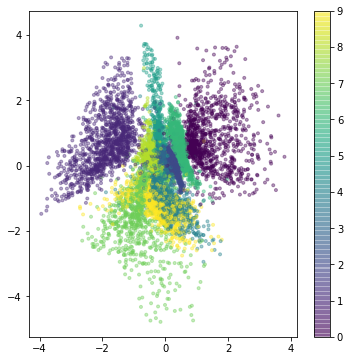

In [20]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [21]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

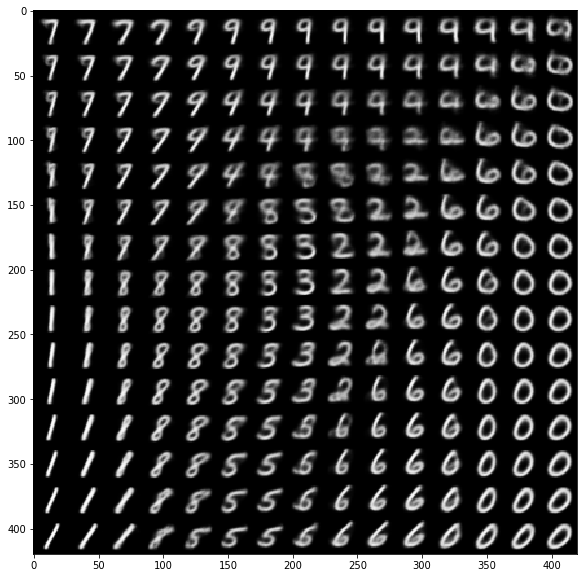

In [22]:
# display a 2D manifold of the generated digits
n = 15 # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed through
# the inverse CDF (ppf) of the Gaussian to produce values of the latent variables z,
# since the prior of the latent space is Gaussian

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
z_grid = np.dstack(np.meshgrid(grid_x, grid_y))

x_pred_grid = generator.predict(z_grid.reshape(n*n, latent_dim)).reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10,10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()